In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sqlite3
import numpy as np
import statsmodels.api as sm
from scipy import stats

Before building the Regression Model we will go through the following steps:
1. Build a dataframe using Part 3's SQL database
2. Check the table elements, rename and drop if necessary
3. Check for duplicate rows and missing or null values
4. Check for outliers

In [3]:
# We will create the dataframe using Part 3's SQL database
db_path = 'C:/Users/mahmu/LHL/Statistical-Modelling-Project/data/stations_institutions.db'

conn = sqlite3.connect(db_path)
df = pd.read_sql_query("SELECT * FROM stations_institutions", conn)

conn.close()

df.head()

,station_name,latitude,longitude,total_bikes,institution name,category,distance,bank_count,bar_count,restaurant_count,total_institutions
0,Summerhill Ave / Maclennan Ave,43.685924,-79.376304,11,Dolce BakeryAshbury CleanersRosedale's FinestR...,restaurantbarbarbarbarbank,209.0,1.0,4.0,1.0,6.0
1,Queen St E / Joseph Duggan Rd,43.667763,-79.308117,18,None,None,NaN,NaN,NaN,NaN,NaN
2,Victoria Park Ave / Danforth Ave,43.691468,-79.288619,18,Il CucinaTD Bank Financial GroupTD Canada Trus...,restaurantbankbank,74.0,2.0,0.0,1.0,3.0
3,Navy Wharf Crt / Bremner Blvd,43.640722,-79.391051,8,Mr. GreekKibo SushiKibo SushiBlue Fin Sushi Bar,restaurantrestaurantbarbar,128.0,0.0,2.0,2.0,4.0
4,420 Wellington St W,43.643834,-79.396649,15,Le Select BistroMira RestaurantLe Select Bistr...,restaurantrestaurantbarbarbarbarbar,179.0,0.0,5.0,2.0,7.0


In [8]:
# Check if all rows and columns are imported
df.shape

(852, 11)

In [6]:
# Checking types of data
df.dtypes

station_name           object
latitude              float64
longitude             float64
total_bikes             int64
institution name       object
category               object
distance              float64
bank_count            float64
bar_count             float64
restaurant_count      float64
total_institutions    float64
dtype: object

In [9]:
# Drop irrelevant columns like institution name and category
df = df.drop(['institution name', 'category'], axis=1)
df.head(5)

,station_name,latitude,longitude,total_bikes,distance,bank_count,bar_count,restaurant_count,total_institutions
0,Summerhill Ave / Maclennan Ave,43.685924,-79.376304,11,209.0,1.0,4.0,1.0,6.0
1,Queen St E / Joseph Duggan Rd,43.667763,-79.308117,18,NaN,NaN,NaN,NaN,NaN
2,Victoria Park Ave / Danforth Ave,43.691468,-79.288619,18,74.0,2.0,0.0,1.0,3.0
3,Navy Wharf Crt / Bremner Blvd,43.640722,-79.391051,8,128.0,0.0,2.0,2.0,4.0
4,420 Wellington St W,43.643834,-79.396649,15,179.0,0.0,5.0,2.0,7.0


In [10]:
# Checking for duplicate rows, there are none, as we have previously cleaned while merging part 1 and 2
duplicate_rows_df = df[df.duplicated()]
print("number of duplicate rows: ", duplicate_rows_df.shape)

number of duplicate rows:  (0, 9)


In [12]:
# There will be null values as there are establishment without any nearby establishment, or API did not have data on it
print(df.isnull().sum())

station_name            0
latitude                0
longitude               0
total_bikes             0
distance              408
bank_count            408
bar_count             408
restaurant_count      408
total_institutions    408
dtype: int64


Dropping nearly half the stations because their values are null is very risky. We have the option to impute data or drop, for now, we will drop and continue onwards.

In [13]:
df = df.dropna()    # Dropping the null values
df.count()

station_name          444
latitude              444
longitude             444
total_bikes           444
distance              444
bank_count            444
bar_count             444
restaurant_count      444
total_institutions    444
dtype: int64

In [29]:
# Check the summary statistics
df.describe()
# We can already see some outliers in total_bikes, bank_count, bar_count and restaurant_count 

,latitude,longitude,total_bikes,distance,bank_count,bar_count,restaurant_count,total_institutions
count,444.000000,444.000000,444.000000,444.000000,444.000000,444.000000,444.000000,444.000000
mean,43.666751,-79.393307,18.500000,161.148649,0.533784,2.567568,1.630631,4.731982
std,0.028859,0.051177,8.036458,134.390860,1.134811,2.332890,1.845881,3.999183
min,43.592742,-79.540330,5.000000,5.000000,0.000000,0.000000,0.000000,1.000000
25%,43.648677,-79.416501,14.000000,56.750000,0.000000,1.000000,1.000000,2.000000
50%,43.659403,-79.390044,16.000000,121.500000,0.000000,2.000000,1.000000,3.000000
75%,43.675508,-79.375868,21.000000,229.250000,1.000000,4.000000,2.000000,7.000000
max,43.781877,-79.215646,63.000000,703.000000,7.000000,10.000000,10.000000,23.000000


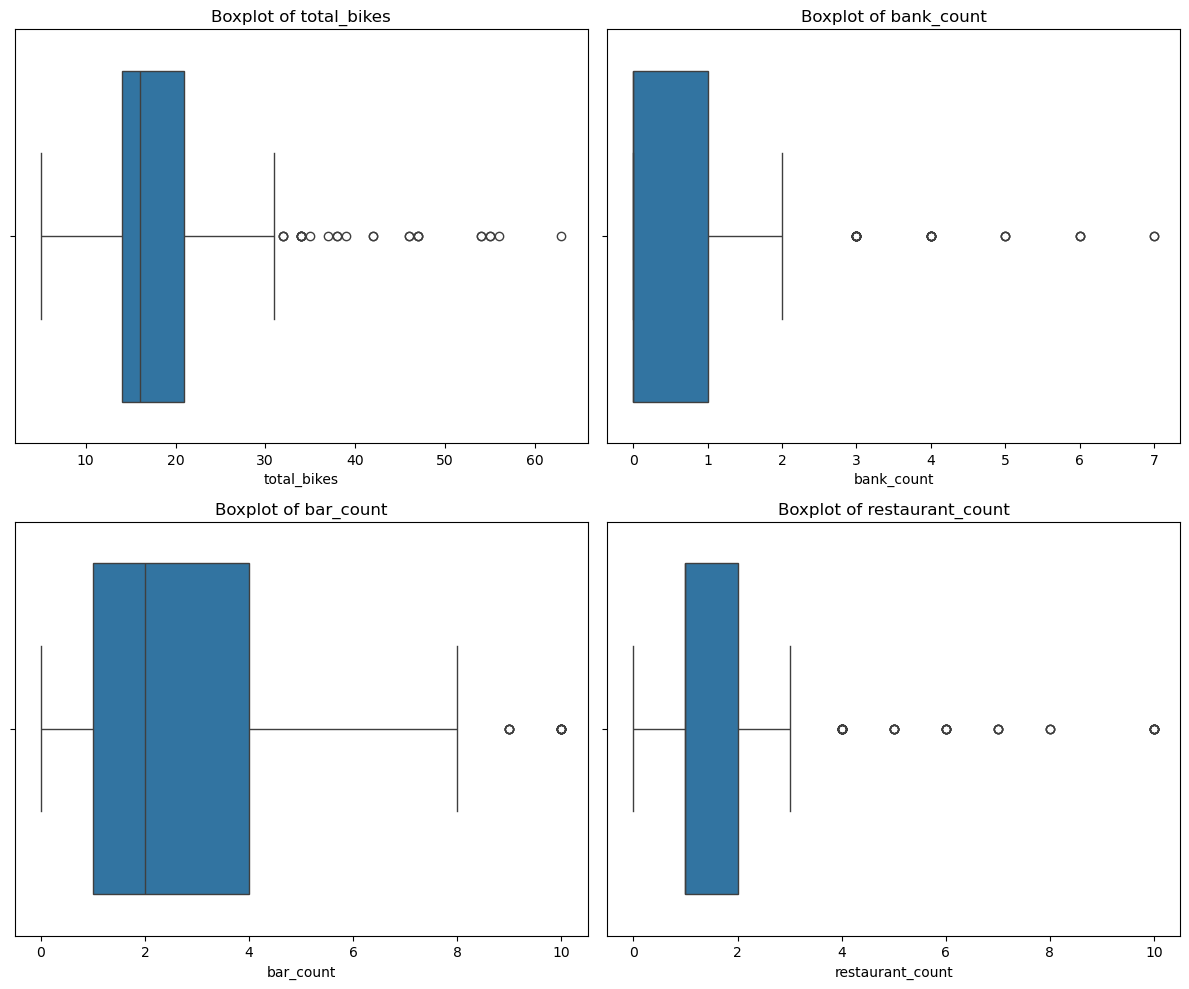

In [30]:
# Checking for outliers visually in these 4
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
columns = ['total_bikes', 'bank_count', 'bar_count', 'restaurant_count']

axes = axes.flatten()

for i, column in enumerate(columns):
    sns.boxplot(x=df[column], ax=axes[i])
    axes[i].set_title(f'Boxplot of {column}')

plt.tight_layout()
plt.show()

There seems to be outlier in all 4 columns. But we will continue without removing too high or too low values for now, it could potentially be a feature of specific bike stations

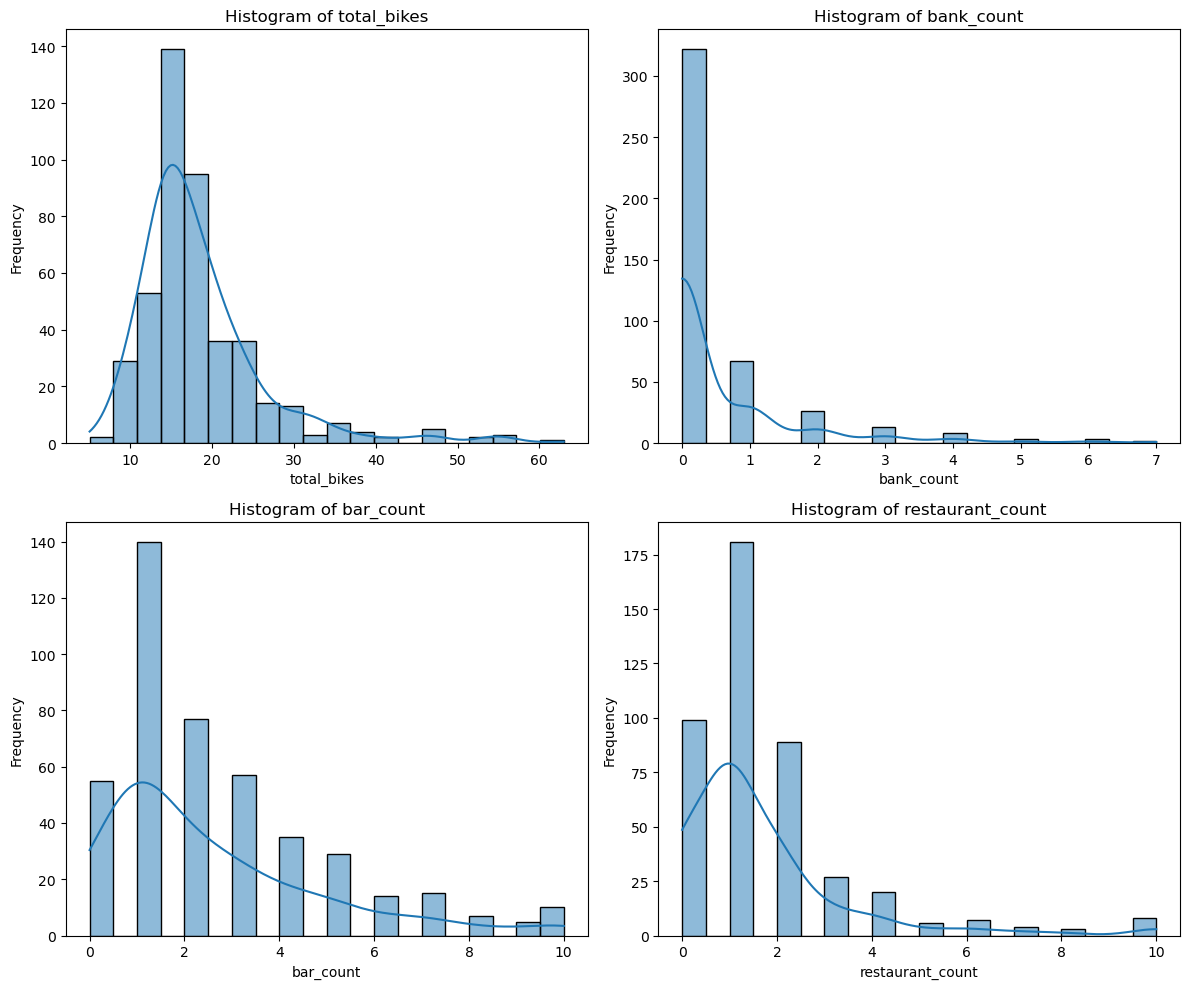

In [25]:
# We will make a histogram for normality check
columns_to_check = ['total_bikes', 'bank_count', 'bar_count', 'restaurant_count']

plt.figure(figsize=(12, 10))

for i, col in enumerate(columns_to_check, 1):
    plt.subplot(2, 2, i) 
    sns.histplot(df[col], kde=True, bins=20)  
    plt.title(f'Histogram of {col}')
    plt.xlabel(col) 
    plt.ylabel('Frequency')

plt.tight_layout() 
plt.show()

All four histogram plots show left-skewed data.

For total_bikes it suggests that most bike stations have a high number of bikes available, with fewer stations having a significantly lower number.

For bank_count, bar_count, restaurant_count, a similar pattern in these columns indicates that most stations are located near a high number of banks, bars, or restaurants, while only a few stations have none or very few establishments nearby.

In [36]:
# For example, we can statistical test for normality in total_bikes
from scipy import stats
stat, p_bikes = stats.shapiro(df['total_bikes'])
print('%0.30f' % p_bikes)
print("p-value of total_bikes is " + str(p_bikes))

0.000000000000000000000048656440
p-value of total_bikes is 4.865644026850256e-23


We can see from histogram, as well as, the p-value that it is not normally distributed. All 4 columns here are not normally distributed. 

# Building a regression model:
### Task: Build a regression model using Python’s `statsmodels` module that demonstrates a relationship between the number of bikes in a particular location and the characteristics of the POIs in that location. 

In [19]:
# Now we can run a regression analysis, first we identify the independent and dependent variables x and y
x = df[['bank_count', 'bar_count', 'restaurant_count']]
y = df['total_bikes']

x = sm.add_constant(x)  

# Then we run regression model using OLS method
model = sm.OLS(y, x).fit()

We can also check the scatter plot our dependent variable Total Bikes vs independent variables (Bank, Bar, Restaurant Count)

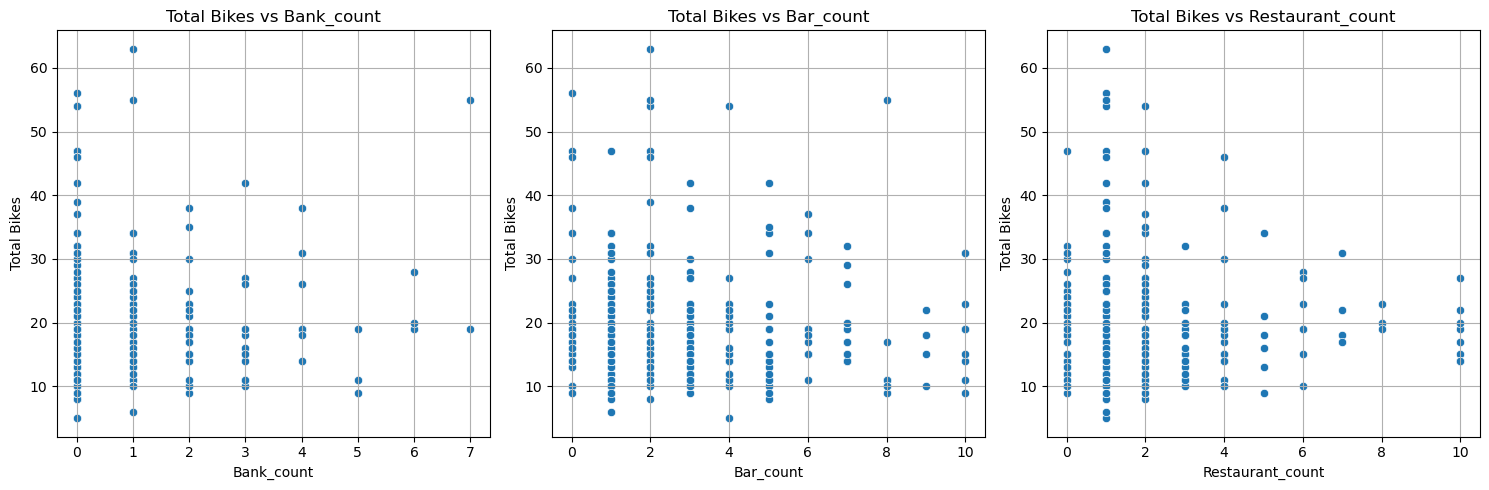

In [26]:
plt.figure(figsize=(15, 5))

# Our independent variables
independent_vars = ['bank_count', 'bar_count', 'restaurant_count']

# Scatter plots for each of them
for i, var in enumerate(independent_vars):
    plt.subplot(1, 3, i + 1)  # 1 row, 3 columns
    sns.scatterplot(x=df[var], y=df['total_bikes'])
    plt.title(f'Total Bikes vs {var.capitalize()}')
    plt.xlabel(var.capitalize())
    plt.ylabel('Total Bikes')
    plt.grid()

plt.tight_layout()
plt.show()

From the scatter plot we cannot see any evident strong correlation between our dependent and independent variables.

Provide model output and an interpretation of the results. 

In [22]:
# Now we can check the model output
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            total_bikes   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     2.359
Date:                Mon, 21 Oct 2024   Prob (F-statistic):             0.0710
Time:                        23:08:58   Log-Likelihood:                -1551.3
No. Observations:                 444   AIC:                             3111.
Df Residuals:                     440   BIC:                             3127.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               18.4360      0.595     31.011      0.000      17.268      19.604
bank_count           0.8951      0.349      2.564      0.011       0.209       1.581
bar_count           -0.1903      0.182     -1.046      0.296      -0.548       0.167
restaurant_count     0.0459      0.229      0.200      0.841      -0.404       0.496
==============================================================================
Omnibus:                      225.180   Durbin-Watson:                   1.958
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1209.763
Skew:                           2.214   Prob(JB):                    2.01e-263
Kurtosis:                       9.766   Cond. No.                         6.53
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The OLS regression results can be inturporeted as below:

* R-squared is 0.016, indicates a weak fit, explaining only 1.6% of the variance in total_bikes.

* F-statistic 2.359 and p-value 0.0710 which suggests the model is not statistically significant at the 0.05 level, although it approaches significance.

* Coef of bank_count is 0.8951 with a significant p value of 0.011 means each additional bank is associated with approximately 0.895 more bikes.

* Coef of bar_count is -0.1903 and restaurant_count is 0.0459, which is not significant, indicating no meaningful impact on bike counts.

Overall, the model suggests a weak relationship between bike numbers and nearby POIs, with only bank_count showing a significant positive effect.

# Stretch

How can you turn the regression model into a classification model?

To transform the regression problem of predicting the number of bikes into a classification problem, we can categorize bike counts into classes, such as low use , medium use , and high use. This involves creating a new target variable based on these categories while retaining features like bank_count, bar_count, and restaurant_count as predictors. We can then select a classification model like logistic regression. Then we can gain insights into how nearby POIs influence bike usage patterns.